# `pyutils` multifile  

## Introduction 

This turorial is intended to show users how to handle multiple input files using `pyutils`, either using local file lists, remote file lists, and SAM definitions. We cover simple array-based processing and more complex custom processing.

## Table of contents
1. Setup
1. Simple processing
1. Complex processing & analysis with the `Skeleton` template class

## 1. Setup

As in [pyutils_basics.ipynb](pyutils_basics.ipynb), we need to add `pyutils` to our Python path.

In [1]:
import sys 
sys.path.append("../../utils/pyutils")

## 2. Simple processing

The `process_data` function from `pyprocess` can be used to multithread processes on a list of EventNtuple files. This will work with both local and remote files. 

The default behaviour is to return the results as a single concatenated awkward array, which works well for small datasets. As will be discussed in example 3, you can customise the "process function" to run whatever task you need against each file, where the output will be a list of results from your function. 



In [2]:
# Import the Processor class from pyprocess 
from pyprocess import Processor 

# Initialise the Processor class instance
# If files are 
processor = Processor(
    use_remote = True, 
    location = "disk",
    verbosity = 2
)

# Define path to list of 10 local files
# "Local" means that each file name includes the full path to a localtion on a local disk, such as `/exp/data`. 
# file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_file_list.txt"
file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/remote_file_list.txt"

# Define branches
# Branches can also be defined as a list of a grouped dict of lists, depending on requirements
branches = [
    "event",
    "trk.nactive",
    "trkqual.result",
    "crvcoincs.PEs",
    "trksegs"
]

# Process the files using multithreading
data = processor.process_data(
    file_list_path = file_list_path, 
    # defname = defname, # Alternatively, you can provide a SAM definition
    branches = branches
)

[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/remote_file_list.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 10 files
[pyprocess] ⭐️ Starting processing on 10 files with 10 threads


Processing: 100%|██████████████████████████████| 10/10 [00:17<00:00,  1.76s/file, successful=10, failed=0]


[pyprocess] ✅ Returning concatenated array containing 70255 events
[pyprocess] 👀 Array structure:
70255 * {
    event: int32,
    "trk.nactive": var * int32,
    trksegs: var * var * struct[{
        mom: struct[{
            fCoordinates: struct[{
                fX: float32,
                fY: float32,
                fZ: float32
            }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
        }, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}],
        pos: struct[{
            fCoordinates: struct[{
                fX: float32,
                fY: float32,
                fZ: float32
            }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
        }, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}],
        time: float64,
        dmom: float32,
        momerr: float32,
       

We now have a concatenated awkward array called `data` which can be used for analysis.

> **Note**: Be mindful of memory constraints with large datasets.

## 3. Complex processing with the `Skeleton` template class
   
The `pyprocess` framework provides tools for complex processing on large datasets where simple array-based approaches become impractical due to memory constraints. The `Skeleton` processor class provides access to pre-written methods which leverage the tools in the main `Processor` class, limiting the amount of custom code required, while also providing the flexiblity to override methods as needed. 

In this example, we will learn how to use the Skeleton to accumulate histograms from multiple files. 

In [3]:
# Import required external packages
import awkward as ak    
import hist

# Import the framework classes
from pyprocess import Skeleton # The base template class that provides structure
from pyimport import Importer # Used to extract the data from ROOT files

# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class MyProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_249.txt"
        
        self.branches = ["crvcoincs.PEs"]
        self.use_remote = True       # Use remote file via mdh
        self.location = "disk"       # File location
        self.use_processes = False   # Use multiproccessing rather than multithreading, if desired
        self.max_workers = 100       # Limit the number of worker threads

        # Now add your own analysis-specific parameters 
        # Histogram configuration: 1000 bins ranging from 0 to 10000
        self.nbins = 1000         
        self.xmin = 0
        self.xmax = 10000
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name):
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local Processor to extract data from this file
            # This uses the configuration parameters in our class
            this_processor = Processor(
                use_remote=self.use_remote, # Use remote file via mdh
                location=self.location,     # File location
                verbosity=0                 # Reduce output in worker threads
            )

            
            # Process this file data and return an array
            this_data = this_processor.process_data(
                file_name=file_name,
                branches=self.branches
            )
            
            # ---- Analysis ----
            
            # Flatten the nested array 
            hist_data = ak.flatten(this_data["crvcoincs.PEs"], axis=None)
            
            # Create histogram object with hist
            # https://pypi.org/project/hist/
            this_hist = hist.Hist(
                hist.axis.Regular(self.nbins, self.xmin, self.xmax, name="PEs", label="PEs")
            )

            # Fill the histogram
            this_hist.fill(hist_data) 
            
            # Return the histogram data
            # This will be appended to a list by the execute method
            return this_hist 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"Error processing {file_name}: {e}")
            return None

# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
my_processor = MyProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
hists = my_processor.execute()

# At this point, 'hists' contains the results from all processed files
# You can now analyze, plot, or save these results

[Skeleton] ⭐️ Skeleton init
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=1
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] ⭐️ Starting processing on 817 files with 100 threads


Processing: 100%|██████████████████████████████| 817/817 [05:18<00:00,  2.56file/s, successful=817, failed=0]

[pyprocess] ⭐️ Returning 817 results
[Skeleton] ✅ Analysis complete


> **Note**: Be mindful of the number of maximum number worker threads when working on a shared machine. If in doubt, use fewer workers, not more. 

At this point, 'hists' contains the results from all processed files
You can now analyse, plot, or save these results

## Postprocessing: combine and plot the results

In [10]:
# Combine the histograms
def combine_histograms(hists):
    """Combine histograms from multiple files
    """
    combined_hist = None
    
    # Check if we have results
    if not hists:
        return None
    
    # Loop through all results
    for hist in hists: 
         # Add this histogram to the accumulated one
        if combined_hist is None: # First one
            combined_hist = hist.copy() 
        else: # Following ones
            combined_hist += hist # hist packages makes this easy
    
    return combined_hist

combined_hist = combine_histograms(hists)

# Check that the combined hist is close to the expected counts (~800 times one file)
print(combined_hist.sum() / hists[0].sum())

797.2223614941088


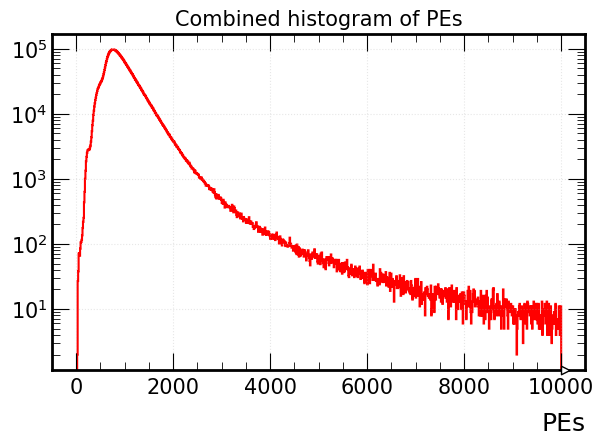

In [6]:
# Now plot
import matplotlib.pyplot as plt
plt.style.use("mu2e.mplstyle")
fig, ax = plt.subplots()
combined_hist.plot()
ax.set_yscale("log")
ax.set_title("Combined histogram of PEs")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("h1_PEs.png", dpi=300)
plt.show()

> **Note**: I am not using `pyplot` here because at present it only works with flattened arrays, not histogram objects.